# Getting To Know Your Features In Seconds With Rapids

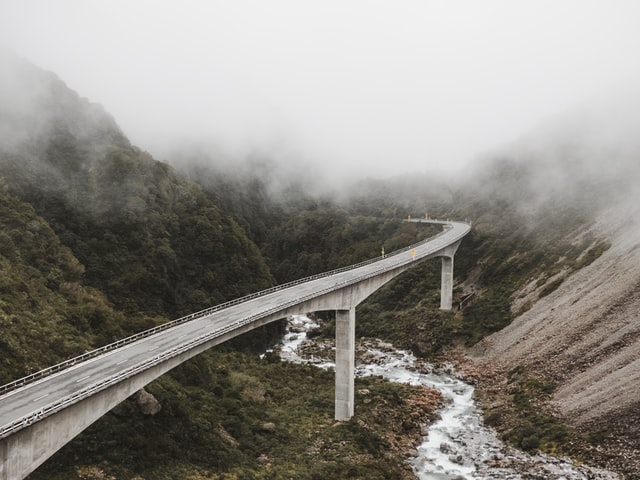
<span><center>Photo by <a href="https://unsplash.com/@lastly?utm_source=unsplash&amp;utm_medium=referral&amp;utm_content=creditCopyText">Tyler Lastovich</a> on <a href="https://unsplash.com/s/photos/rapids?utm_source=unsplash&amp;utm_medium=referral&amp;utm_content=creditCopyText">Unsplash</a></center></span>

Exploratory data analysis, and especially getting an idea of features importance, is a crucial step when confronted with a data science problem. However, this step can often be trying if your database is huge, with numerous interconnexions, making the analysis costly in computing time.

GPUs are great at improving computing time... if you can use them ! Indeed, their use is often dedicated to training neural networks, thanks to powerful frameworks (TensorFlow or PyTorch are the most famous) that have enabled millions of developers to unleash their incredible powers.

However, if you have some dirty preprocessing to get done with Pandas or sklearn, that can be quite heavy if your data is big. These packages don’t support GPUs and to sum things up, you won't be able to get the most out of your GPU at this stage.

[*RAPIDS*](https://developer.nvidia.com/rapids) is a suite of packages developed out of NVIDIA, that intends to execute end-to-end data science and analytics pipelines entirely on GPUs.

The goal of this notebook is to perform univariate regressions of each target on every feature, namely *872 x 206 = 179632* logistic models to estimate separately. The good news ? **This is possible within minutes with *RAPIDS* !** 

You can note that I never import neither Pandas (replaced by cuDF) nor scikit-learn (replaced by cuML). 

This notebook will be a tutorial, aiming at helping you get familiar using these libraries.

At the end of this notebook, you'll be able to select, among your features, those which appear to be the most crucial in predicting your targets. 

That will enable you to build robust, medium-sized models with better interpretability.

If you want to skip the processing and jump to the results, you can take a look [here](https://www.kaggle.com/louise2001/moa-feat-importance-rapids).

In [ ]:
import sys
!cp ../input/rapids/rapids.0.16.0 /opt/conda/envs/rapids.tar.gz
!cd /opt/conda/envs/ && tar -xzvf rapids.tar.gz > /dev/null
sys.path = ["/opt/conda/envs/rapids/lib/python3.7/site-packages"] + sys.path
sys.path = ["/opt/conda/envs/rapids/lib/python3.7"] + sys.path
sys.path = ["/opt/conda/envs/rapids/lib"] + sys.path
!cp /opt/conda/envs/rapids/lib/libxgboost.so /opt/conda/lib/

Import the rapids functions that will be necessary :

In [ ]:
import cudf
import cuml
from cuml.linear_model import LogisticRegression
from cuml.metrics import log_loss
from cuml.experimental.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm.notebook import tqdm

In [ ]:
INPUT_DATA = r"../input/lish-moa/"

In [ ]:
%%time
Train = cudf.read_csv(INPUT_DATA+"train_features.csv")
Target_scored = cudf.read_csv(INPUT_DATA+'train_targets_scored.csv')
Train.shape

In [ ]:
%%time
Train = Train.merge(Target_scored,how='left',on="sig_id")

In [ ]:
ID = ['sig_id']
CP = ['cp_type','cp_time','cp_dose']
G = [x for x in Train.columns if 'g-' in x]
C = [x for x in Train.columns if 'c-' in x]
Targets = Target_scored.columns[1:].tolist()
len(C),len(G),len(Targets)

At this stage, I'm reporting the log_loss, also known as binary cross-entropy loss, as an importance metric : indeed, the better a feature explains a given target (the lower the log-loss), the more important that feature will be in predicting the target. However, we will later need a bijective, strictly decreasing transformation of that log-loss to fit the intuition that feature importance should be increasing when the loss diminishes.

In [ ]:
def FeaturesImportance(val):
    target, feat = val
    clf = LogisticRegression().fit(Train[feat].values.reshape(-1,1), Train[target])
    prob = clf.predict_proba(Train[feat].values.reshape(-1,1))
    loss = log_loss(Train[target],prob)
    return cudf.DataFrame({"Feature":[feat],target:[loss]})

Univariate regressions of each target on every feature : if you don't want to run the 40 minutes processing, you can directly read the results which I have saved in this dataset : https://www.kaggle.com/louise2001/moa-feat-importance-rapids.

In [ ]:
if False:
    %%time
    for target in tqdm(Targets):

        all_feat = [(target,f) for f in C+G]
        df = []

        for i in range(len(all_feat)):
            df.append(FeaturesImportance(all_feat[i]))

        temp = cudf.concat(df).sort_values('Feature')

        if target == Targets[0]:
            output = temp.copy()

        else:
            output[target] = temp[target]
    output = output.set_index("Feature")
else:
    output = cudf.read_csv('../input/moa-feat-importance-rapids/output_source.csv', index_col=0)
output.sample(5)

Wow, that's pretty impressive ! Now, just as we do a to_cpu() after CUDA computing on PyTorch, we can just convert everything back to Pandas. However, I will stay with RAPIDS in the following.

In [ ]:
# output = output.to_pandas()

In [ ]:
output_ = output.copy(deep=True)

In [ ]:
output_.min().min(), output_.max().max(), output_.std().mean()

The log-loss is theoretically comprised between 0 (perfect classifier) and +infinity (perfectly wrong classifier), but in our case its values seem to be rather contracted from 6.3e-4 to 0.1515. That's a very narrow range, not very easy to analyze, given also the very small standard deviation. 

For comparison and ranking purposes, we need the features importances for each target to be decreasing with the log-loss (that's more intuitive. You expect feature importance to be, well, an importance, right ?). The lower the log-loss, the better the feature is at predicting the target, and the higher the feature importance.

Also, if you want to compare features in order to keep some and dismiss others, you need them to be in "the same unit", if that makes sense.

We will see in the following that it allows us to split our data very easily in 2 groups, the features we keep and the ones we dismiss.

This is why, for each target, we rescale its corresponding features log-losses to [0, 1] while inversing the order of values so that the interpretation as a "feature importance" is more intuitive.

In [ ]:
output_scaled = output_.copy(deep=True)
for c in output_scaled.columns:
    output_scaled[c] = (1 - MinMaxScaler().fit_transform(output_[[c]])).round(14).values
output_scaled.min().min(), output_scaled.max().max(), output_scaled.std().mean()

Calculating a feature's average importance on all targets is important to get a global view of how crucial it can be on your overall model. 

However, I'm not sure you should rely entirely on this indicator when discriminating between features to keep and features to dismiss : indeed, a given feature could have a very high explainability power on one specific target, and be irrelevant on all others, therefore even though it would receive a low average importance score, keeping it would be decisive in final model quality for that target.

In [ ]:
thresh_mean, thresh_max = 0.35, 0.975
fig = plt.figure(figsize=(20,10))
ax, ax2 = fig.add_subplot(2, 1, 1), fig.add_subplot(2, 1, 2)
ax.hist(output_scaled.mean(axis=1).to_pandas(), bins=100, density=True)
ax.axvline(x=thresh_mean, ls='--', c='red', linewidth=0.5)
ax.set_title('Histogram of Mean Feature Importance distribution')
ax2.hist(output_scaled.max(axis=1).to_pandas(), bins=100, density=True)
ax2.axvline(x=thresh_max, ls='--', c='red', linewidth=0.5)
ax2.set_title('Histogram of Max Feature Importance distribution')
plt.show()

In [ ]:
output_scaled["MeanImp"] = output_scaled[Targets].mean(axis=1)
output_scaled["MaxImp"]  = output_scaled[Targets].max(axis=1)

Here, I will save apart separately :
- The features which are above *both* thresholds on mean importance and max importance ;
- The features which are above *one* of the thresholds on mean importance and max importance.

In [ ]:
fs_both        = output_scaled.loc[(output_scaled.MeanImp >= thresh_mean) & (output_scaled.MaxImp >= thresh_max), Targets]
fs_any         = output_scaled.loc[(output_scaled.MeanImp >= thresh_mean) | (output_scaled.MaxImp >= thresh_max), Targets]
fs_out_of_both = output_scaled.loc[(output_scaled.MeanImp < thresh_mean) & (output_scaled.MaxImp < thresh_max), Targets]
output_scaled.shape[0], fs_both.shape[0], fs_any.shape[0], fs_out_of_both.shape[0]

Out of 872 samples, we have kept 187 features that fulfill either of the two criterias of minimum average importance or maximal importance. That seems a good skimming proportion.

Now, I will also save some interesting summaries of results : comparing, on features either in none of the categories or in both, the mean and max importance they have by target. You can find them in [the dataset](https://www.kaggle.com/louise2001/moa-feat-importance-rapids) as well.

In [ ]:
summary_mean_importance = cudf.concat([fs_out_of_both.mean(axis=0), fs_any.mean(axis=0), fs_both.mean(axis=0)], axis=1)
summary_mean_importance.columns = ['Out of both', 'In Any', 'In Both']
summary_max_importance = cudf.concat([fs_out_of_both.max(axis=0), fs_any.max(axis=0), fs_both.max(axis=0)], axis=1)
summary_max_importance.columns = ['Out of both', 'In Any', 'In Both']

In [ ]:
for summary, metric in zip([summary_mean_importance, summary_max_importance], ['mean', 'max']):
    print(f"Summary for {metric}")
    print(f"Average Difference in-both / out-of-both : {(summary['In Both'] - summary['Out of both']).mean().round(2)}")
    print(f"Average Difference in-any / out-of-both : {(summary['In Any'] - summary['Out of both']).mean().round(2)}")

Interpretation : 
- The features that fulfill both criteria have, on average on all targets, 0.15 more average importance than the features that don't fulfill any of the criterias.
- The features that fulfill one of the criteria have, on average on all targets, 0.19 more maximum importance than the features that don't fulfill any of the criterias.

To get a global overview, we can just compare heatmaps of scaled feature importance by target on the two subsets, the features that fulfill both criterias and the ones that don't fulfill any. It becomes visible immediately that the fist graph is much lighter - the importances are higher.

In [ ]:
fig = plt.figure(figsize=(20,5))
ax, ax2 = fig.add_subplot(1, 2, 1), fig.add_subplot(1, 2, 2)
sns.heatmap(fs_both[Targets].to_pandas(), ax=ax)
sns.heatmap(fs_out_of_both[Targets].to_pandas(), ax=ax2)
plt.savefig('feature_importance.jpg')

Thanks for reading me !